Automation of Feature Creation

src : https://www.kaggle.com/datasets/blackbee2016/automation-of-feature-creation/data
columns : 669 columns

In [19]:
!pip install pip==23.2.1 setuptools==65.5.1

In [20]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [21]:
# connect S3 bucket
bucket = "mscproject05"
datakey = "train.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject05/train.csv


In [22]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [23]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,...,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5,LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225,LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28,"LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]",LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45,LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175,LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 16549.6725,LabelPYEARS_BEGINEXPLUATATION_AVG,ProbTARGET1
0,24700.5,406597.5,351000.0,M,-9461,-637,-2120,2.0,2.0,0.083037,...,]17504865;+inf[,]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]96.5;+inf[,]-inf;5925941.5],]-inf;0.97345],0.246611
1,35698.5,1293502.5,1129500.0,F,-16765,-1188,-291,0.0,0.0,0.311267,...,]5044331;17504865],]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]9.5;96.5],]5925941.5;+inf[,]0.97345;0.99035],0.011116
2,6750.0,135000.0,135000.0,M,-19046,-225,-2531,0.0,0.0,NaN,...,]5044331;17504865],]5055192.5;33971364],]-inf;0.5],]-inf;18152.6625],]-inf;-107062],]-inf;-55391],]-inf;9.5],]-inf;5925941.5],]-inf;0.97345],0.027319
3,29686.5,312682.5,297000.0,F,-19005,-3039,-2437,0.0,0.0,NaN,...,]-inf;5044331],]-inf;5055192.5],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-7612.5;+inf[,]9.5;96.5],]5925941.5;+inf[,]-inf;0.97345],0.084332
4,21865.5,513000.0,513000.0,M,-19932,-3038,-3458,0.0,0.0,NaN,...,]5044331;17504865],]-inf;5055192.5],]-inf;0.5],]18152.6625;+inf[,]-107062;+inf[,]-55391;-7612.5],]96.5;+inf[,]5925941.5;+inf[,]-inf;0.97345],0.056745


In [24]:
df.shape

(307511, 335)

In [25]:
df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CODE_GENDER',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_1',
       ...
       'LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5',
       'LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5',
       'LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225',
       'LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28',
       'LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]',
       'LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45',
       'LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175',
       'LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 165

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float64(133), int64(22), object(180)
memory usage: 786.0+ MB


In [27]:
df.duplicated().sum()

0

In [28]:
print(df.isnull().sum()[df.isnull().sum() > 0])

AMT_ANNUITY                                                                                               12
AMT_GOODS_PRICE                                                                                          278
DEF_30_CNT_SOCIAL_CIRCLE                                                                                1021
DEF_60_CNT_SOCIAL_CIRCLE                                                                                1021
EXT_SOURCE_1                                                                                          173378
                                                                                                       ...  
Sum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28                       99218
Sum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]    141660
Sum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45                     145186
Sum(installments_pa

In [29]:
df.sample(1) 

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,...,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5,LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225,LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28,"LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]",LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45,LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175,LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 16549.6725,LabelPYEARS_BEGINEXPLUATATION_AVG,ProbTARGET1
19499,13500.0,270000.0,270000.0,F,-15295,-960,-5016,0.0,0.0,NaN,...,]-inf;5044331],]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]9.5;96.5],]5925941.5;+inf[,]-inf;0.97345],0.008989


In [30]:
# Get columns where more than 75% but less than 100% of values are NaN
null_columns_75 = df.columns[(df.isnull().mean() > 0.75) & (df.isnull().mean() < 1.0)]

# Convert to list if needed
null_columns_75_list = list(null_columns_75)

# Print the column names
print("Columns with more than 75% null values (but not 100%):")
for col in null_columns_75_list:
    print(col)


Columns with more than 75% null values (but not 100%):
Max(POS_CASH_balance_train.csv.MONTHS_BALANCE) where SK_DPD > 0.5
Max(bureau_train.csv.CREDIT_DAY_OVERDUE) where AMT_CREDIT_SUM_OVERDUE > 0.0225
Max(bureau_train.csv.DAYS_CREDIT_UPDATE) where CREDIT_DAY_OVERDUE > 0.5
Mean(POS_CASH_balance_train.csv.CNT_INSTALMENT_FUTURE) where CNT_INSTALMENT > 24.5
Mean(credit_card_balance_train.csv.AMT_CREDIT_LIMIT_ACTUAL) where AMT_BALANCE <= 0.0225
Median(bureau_train.csv.AMT_CREDIT_SUM) where AMT_CREDIT_SUM_OVERDUE > 0.0225
Min(bureau_train.csv.AMT_CREDIT_SUM_LIMIT) where AMT_CREDIT_SUM_LIMIT > 0.0225
Min(credit_card_balance_train.csv.AMT_DRAWINGS_OTHER_CURRENT)
Mode(bureau_balance_preprocessed_train.csv.STATUS) where STATUS not in {C, 0, X}
StdDev(POS_CASH_balance_train.csv.SK_DPD_DEF) where CNT_INSTALMENT > 24.5
StdDev(credit_card_balance_train.csv.AMT_DRAWINGS_ATM_CURRENT)
Sum(POS_CASH_balance_train.csv.MONTHS_BALANCE) where CNT_INSTALMENT > 24.5
Sum(credit_card_balance_train.csv.CNT_DRAWING

In [32]:
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Impute numeric columns with mean
num_imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


In [33]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [34]:
# Select categorical columns (object or category dtype)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Show unique value counts for each categorical column
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


CODE_GENDER: 3 unique values
FLAG_OWN_CAR: 2 unique values
NAME_CONTRACT_TYPE: 2 unique values
NAME_EDUCATION_TYPE: 5 unique values
NAME_FAMILY_STATUS: 6 unique values
NAME_INCOME_TYPE: 8 unique values
OCCUPATION_TYPE: 18 unique values
ORGANIZATION_TYPE: 58 unique values
Mode(bureau_train.csv.CREDIT_ACTIVE) where CREDIT_CURRENCY = currency 1: 3 unique values
Mode(bureau_train.csv.CREDIT_ACTIVE) where DAYS_CREDIT_ENDDATE > -426.5: 3 unique values
Mode(bureau_train.csv.CREDIT_TYPE) where AMT_CREDIT_SUM_DEBT > 0.0675: 11 unique values
Mode(previous_application_train.csv.CODE_REJECT_REASON): 9 unique values
Mode(previous_application_train.csv.NAME_CONTRACT_STATUS): 4 unique values
Mode(previous_application_train.csv.NAME_SELLER_INDUSTRY): 11 unique values
LabelPAMT_ANNUITY: 43 unique values
LabelPAMT_CREDIT: 19 unique values
LabelPAMT_GOODS_PRICE: 10 unique values
LabelPCODE_GENDER: 2 unique values
LabelPCount(POS_CASH_balance_train.csv) where CNT_INSTALMENT_FUTURE in ]3.5, 7.5]: 3 unique 

In [35]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Encode all categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = le.fit_transform(df[col].astype(str))


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float64(155), int64(180)
memory usage: 786.0 MB


In [37]:
# Reduce memory

from numpy import float64, float32, int64, int32, dtype

map_dtypes = {
    'int': dtype(int64),
    'float': dtype(float32)
    }

for col in df:
    if df[col].dtype == dtype(int64):
        df[col] = df[col].astype(int32)
    if df[col].dtype == dtype(float64):
        df[col] = df[col].astype(float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float32(155), int32(180)
memory usage: 393.0 MB


In [39]:
# y: target variable
y = df['ProbTARGET1']

# X: drop target column to keep only features
X = df.drop(columns=['ProbTARGET1'])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First few y values:\n", y.head())


Shape of X: (307511, 334)
Shape of y: (307511,)
First few y values:
 0    0.246611
1    0.011116
2    0.027319
3    0.084332
4    0.056745
Name: ProbTARGET1, dtype: float32


In [45]:
from sklearn.model_selection import train_test_split

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (246008, 334)
X_test shape: (61503, 334)
y_train shape: (246008,)
y_test shape: (61503,)


In [46]:
# Clean the column names by replacing special characters with underscores
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# FInd Algorithem = XGboot

In [64]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

In [65]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [66]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [67]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

In [68]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [69]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

In [70]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [71]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [72]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [73]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [74]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [75]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 334 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/20 | Best MSE: 0.000741 | Avg MSE: 0.000827
Gen 06/20 | Best MSE: 0.000712 | Avg MSE: 0.000722
Gen 11/20 | Best MSE: 0.000696 | Avg MSE: 0.000708
Gen 16/20 | Best MSE: 0.000689 | Avg MSE: 0.000696
Gen 20/20 | Best MSE: 0.000689 | Avg MSE: 0.000692

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.000688
▶ Time elapsed: 1127.08 seconds
▶ Features selected: 191/334 (42.8% reduction)

▶ Selected features:
1. AMT_ANNUITY
2. AMT_CREDIT
3. AMT_GOODS_PRICE
4. CODE_GENDER
5. DAYS_EMPLOYED
6. DEF_30_CNT_SOCIAL_CIRCLE
7. DEF_60_CNT_SOCIAL_CIRCLE
8. EXT_SOURCE_1
9. EXT_SOURCE_2
10. EXT_SOURCE_3
11. FLOORSMAX_MEDI
12. FLOORSMAX_MODE
13. FLOORSMIN_MEDI
14. NAME_CONTRACT_TYPE
15. NAME_EDUCATION_TYPE
16. NAME_FAMILY_STATUS
17. NAME_INC

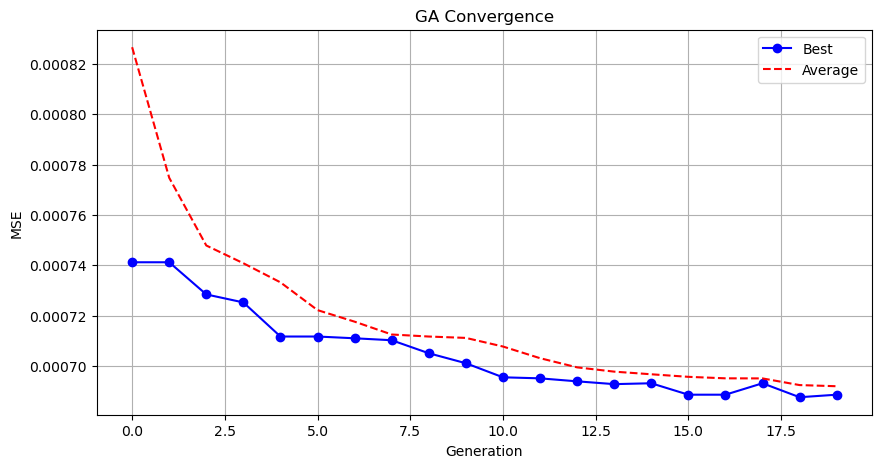

Genetic Algorithm completed successfully with MSE: 0.0007

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 334 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.000766
Best after iteration 1: [0.51839327 0.1361722  0.29723733 0.7087057  0.38920534 0.62911788
 0.2770618  0.45818377 0.79413737 0.21369897 0.56606028 0.73410365
 0.16070898 0.21537188 0.29415151 0.43235522 0.08804306 0.74824019
 0.06848041 0.47212919 0.79524828 0.82814158 0.77849597 0.23668248
 0.97027806 0.55995558 0.49655688 0.40079845 0.0902889  0.58849194
 0.31660699 0.66116915 0.4067177  0.7980733  0.30495422 0.35796357
 0.4366817  0.55441946 0.5534811  0.17062467 0.74408581 0.16765133
 0.36695847 0.28021433 0.12858709 0.58108963 0.83382305 0.20864266
 0.23754904 0.51684386 0.39214

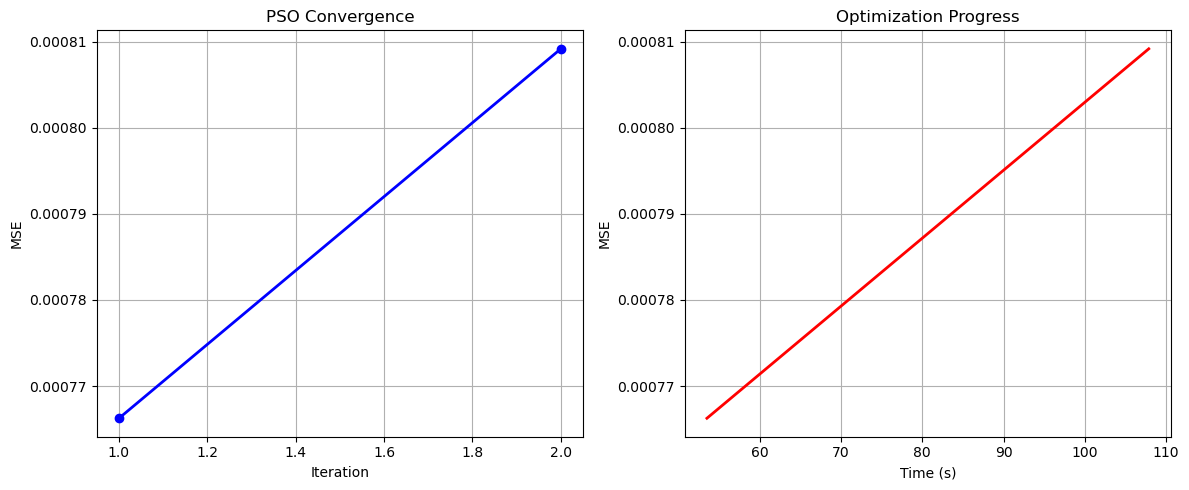

Particle Swarm Optimization completed successfully with MSE: 0.0008

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 334 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.000667

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.000667
▶ Time elapsed: 1857.54 seconds
▶ Features selected: 334/334 (0.0% reduction)

▶ Selected features:
1. AMT_ANNUITY
2. AMT_CREDIT
3. AMT_GOODS_PRICE
4. CODE_GENDER
5. DAYS_BIRTH
6. DAYS_EMPLOYED
7. DAYS_ID_PUBLISH
8. DEF_30_CNT_SOCIAL_CIRCLE
9. DEF_60_CNT_SOCIAL_CIRCLE
10. EXT_SOURCE_1
11. EXT_SOURCE_2
12. EXT_SOURCE_3
13. FLAG_DOCUMENT_3
14. FLAG_EMP_PHONE
15. FLAG_OWN_CAR
16. FLOORSMAX_MEDI
17. FLOORSMAX_MODE
18. FLOORSMIN_MEDI
19. LIVINGAPARTMENTS_MEDI
20. LIVINGAREA_AVG
21. NAME_CONTRACT_TYPE
22. NAME_EDUCATION_TYPE
23. NAME_FAMILY_STATUS
24. NAME_INCOME_TYPE
25. OCCUPATION_TY

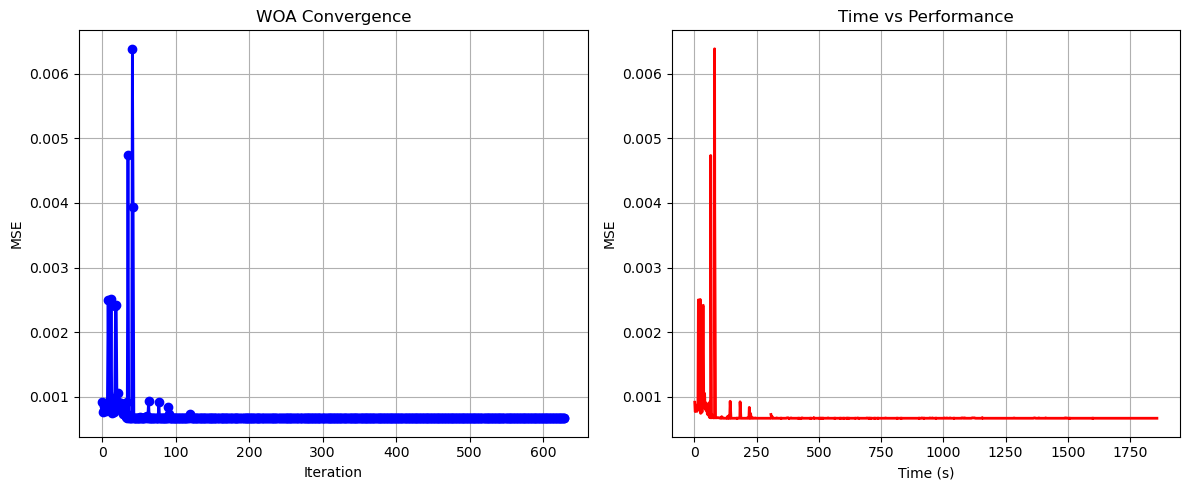

Whale Optimization completed successfully with MSE: 0.0007

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 334 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.000709
▶ Time elapsed: 1042.50 seconds
▶ Features selected: 157/334 (53.0% reduction)

▶ Selected features:
1. AMT_GOODS_PRICE
2. EXT_SOURCE_1
3. EXT_SOURCE_2
4. EXT_SOURCE_3
5. FLAG_DOCUMENT_3
6. FLOORSMAX_MODE
7. LIVINGAPARTMENTS_MEDI
8. LIVINGAREA_AVG
9. NAME_CONTRACT_TYPE
10. OCCUPATION_TYPE
11. Count_POS_CASH_balance_train_csv__where_CNT_INSTALMENT_FUTURE_in__3_5__7_5_
12. Count_POS_CASH_balance_train_csv__where_MONTHS_BALANCE____12_5
13. Count_bureau_train_csv__where_CREDIT_ACTIVE____Closed
14. Count_bureau_train_csv__where_DAYS_CREDIT_ENDDATE____426_5
15. CountDistinct_bureau_balance_preprocessed_train_csv_STATUS__where_STATUS_not_in__C__0__X_
16. CountDistin

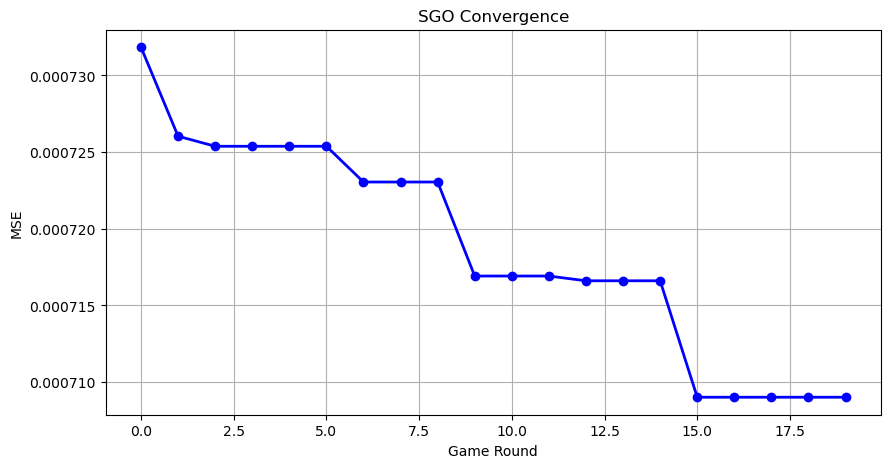

Squid Game Optimizer completed successfully with MSE: 0.0007

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 334 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.000710 | Radius: 0.0250

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.000710
▶ Time elapsed: 3298.27 seconds
▶ Features selected: 175/334 (47.6% reduction)

▶ Selected features (with weights):
1. AMT_GOODS_PRICE (weight: 0.903)
2. CODE_GENDER (weight: 0.711)
3. DAYS_BIRTH (weight: 0.690)
4. DEF_30_CNT_SOCIAL_CIRCLE (weight: 0.915)
5. EXT_SOURCE_2 (weight: 0.637)
6. EXT_SOURCE_3 (weight: 0.759)
7. FLAG_EMP_PHONE (weight: 0.849)
8. FLAG_OWN_CAR (weight: 0.997)
9. FLOORSMAX_MEDI (weight: 0.799)
10. LIVINGAPARTMENTS_MEDI (weight: 0.635)
11. NAME_CONTRACT_TYPE (weight: 0.726)
12. NAME_EDUCATION_TYPE (weight: 0.775)
13. NAME_I

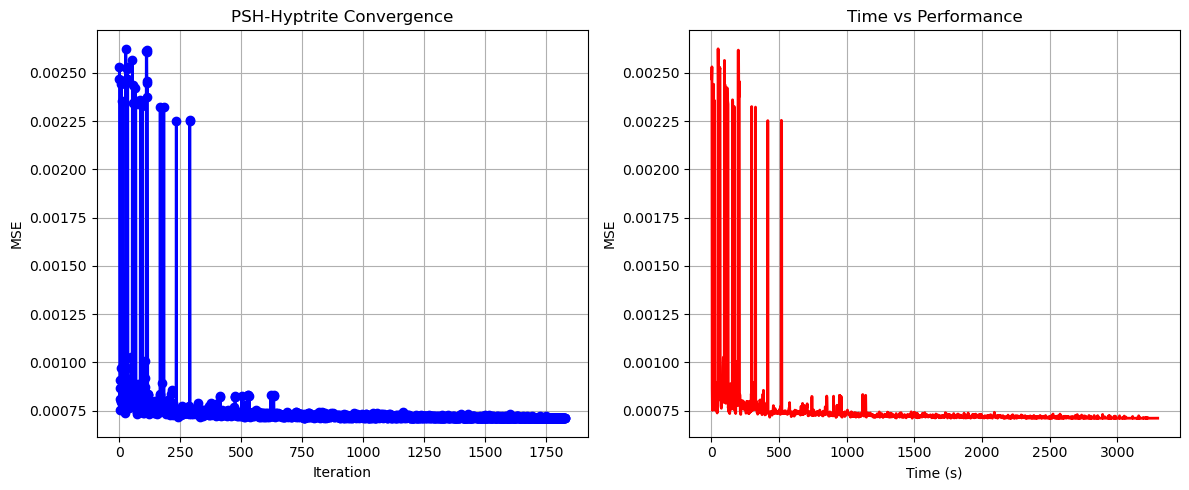

PSH-Hyptrite completed successfully with MSE: 0.0007


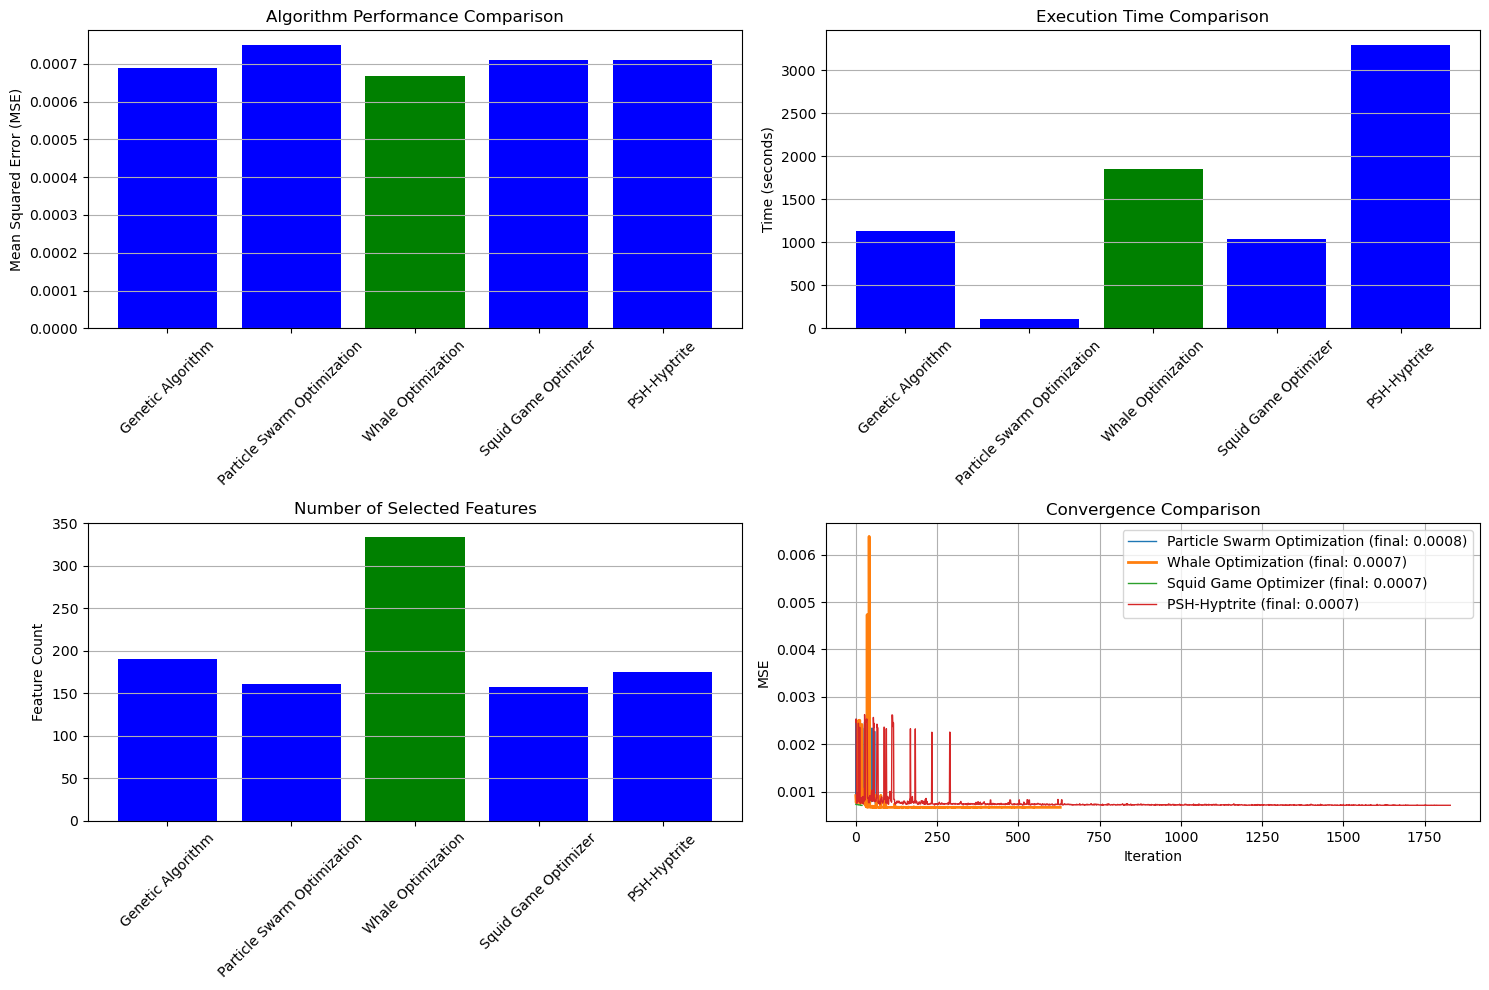


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Whale Optimization
📉 Best MSE Achieved: 0.000667
⏱️ Execution Time: 1857.54 seconds
🔢 Features Selected: 334

Selected Features:
1. AMT_ANNUITY
2. AMT_CREDIT
3. AMT_GOODS_PRICE
4. CODE_GENDER
5. DAYS_BIRTH
6. DAYS_EMPLOYED
7. DAYS_ID_PUBLISH
8. DEF_30_CNT_SOCIAL_CIRCLE
9. DEF_60_CNT_SOCIAL_CIRCLE
10. EXT_SOURCE_1
11. EXT_SOURCE_2
12. EXT_SOURCE_3
13. FLAG_DOCUMENT_3
14. FLAG_EMP_PHONE
15. FLAG_OWN_CAR
16. FLOORSMAX_MEDI
17. FLOORSMAX_MODE
18. FLOORSMIN_MEDI
19. LIVINGAPARTMENTS_MEDI
20. LIVINGAREA_AVG
21. NAME_CONTRACT_TYPE
22. NAME_EDUCATION_TYPE
23. NAME_FAMILY_STATUS
24. NAME_INCOME_TYPE
25. OCCUPATION_TYPE
26. ORGANIZATION_TYPE
27. OWN_CAR_AGE
28. REGION_POPULATION_RELATIVE
29. REGION_RATING_CLIENT
30. REGION_RATING_CLIENT_W_CITY
31. REG_CITY_NOT_LIVE_CITY
32. REG_CITY_NOT_WORK_CITY
33. SK_ID_CURR
34. TARGET
35. YEARS_BEGINEXPLUATATION_AVG
36. Count_POS_CASH_balance_train_csv__where_CNT_INSTALMENT_FUTURE_in__3_5__7_5_
37. Count_POS_CASH_bal

In [76]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)